# Preprocesamiento y EDA

Antes de seleccionar los modelos, se debe realizar un análisis de los datos con los que estamos trabajando. Así, se podrá elegir el mejor modelo para implementar.

El dataset con que estamos trabajando contiene señales EEG de sujetos de dos grupos, alcohólicos o controles. Se presentaron uno o dos estímulos (S1 o S1 y S2) en condiciones coincidentes (S1 = S2) o no coincidentes (S1 ̸= S2), con el objetivo de registrar la actividad cerebral mediante EEG durante el procesamiento visual y la toma de decisiones.

Sin embargo, la data se encuentra en un archivo .h5, que está diseñado para almacenar grandes cantidades de datos complejos. Por esta razón, no se puede trabajar de forma directa con el archivo.

Es por ello que se ha realizado un pipeline que extrae las caracteríticas más relevantes de nuestra base de datos (estamos trabajando con series de tiempo) y almacena dichos resultados en archivos .csv, que son más fáciles de manejar.

In [26]:
# Se importan las librerías necesarias para el procesamiento de datos y la extracción de características (tsfresh)
import os
import h5py
import pandas as pd
import numpy as np
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt
import seaborn as sns

Usaremos la librería h5py para abrir y leer archivos .h5:

In [3]:
train_file = "../train.h5"
test_file = "../test.h5"

with h5py.File(train_file, "r") as f:
    X_train = f["x"][:]   # señales EEG
    y_train = f["y"][:]   # etiquetas

with h5py.File(test_file, "r") as f:
    X_test = f["x"][:]    # señales EEG

# Exploración rápida
print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)
print(X_train[0,0,:5])  # primeras 5 muestras de EEG del primer sujeto
print(y_train[:5])       # primeras 5 etiquetas

(204, 1, 18530) float64
(204,) int64
[-0.00585938 -0.01141357 -0.01077271 -0.01055908 -0.0088501 ]
[0 1 0 0 0]


Se puede observar que la base de datos tiene registros de 204 personas. X_train contiene un atributo "y" que corresponde a las etiquetas, es decir, a los outputs (0 para control y 1 para alcoholicos). Este atributo fue guardado en y_train. Para cada persona, hay un total de 18530 registros de puntos que corresponden a su electroencefalograma. X_test contiene a otras 204 personas con sus respectivas muestras de EEG.

In [7]:
# Visualización de y_train 
y_train 
# Vemos que es un atributo binario (0 y 1)

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1])

Se hizo un análisis de la distribución de los valores de y_train

In [8]:
# Análisis de distribución de clases
y, counts = np.unique(y_train, return_counts=True)
for label, count in zip(y, counts):
    print(f"Clase {label}: {count} muestras, proporción: {count/len(y_train):.2%}")

Clase 0: 149 muestras, proporción: 73.04%
Clase 1: 55 muestras, proporción: 26.96%


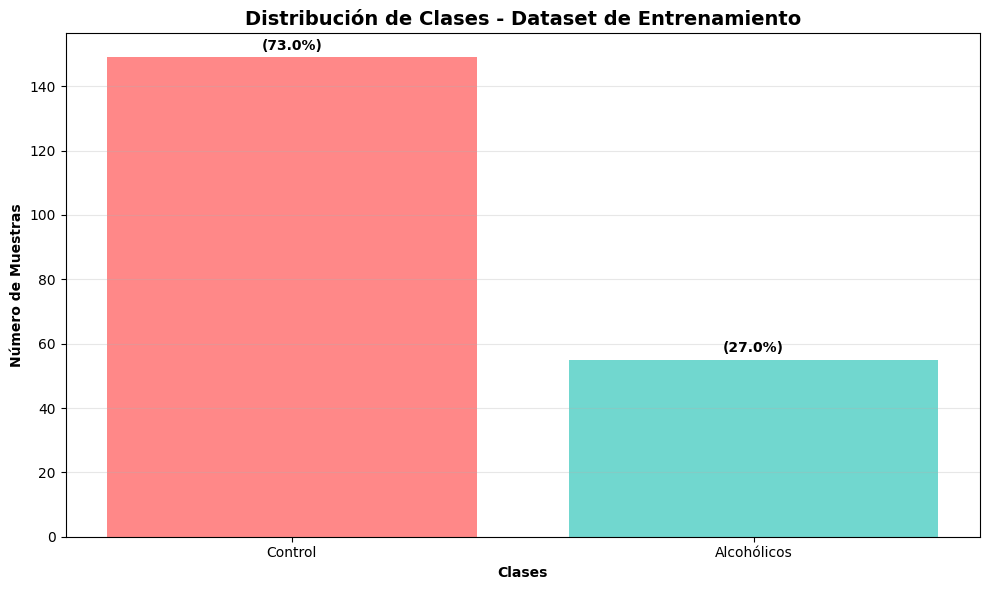

In [44]:
labels = ['Control', 'Alcohólicos']  # Clase 0: Control, Clase 1: Alcohólicos
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, counts, color=['#ff6b6b', '#4ecdc4'], alpha=0.8)
# Añadir valores en las barras
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
             f'({count/len(y_train):.1%})', 
             ha='center', va='bottom', fontweight='bold')

plt.title('Distribución de Clases - Dataset de Entrenamiento', fontsize=14, fontweight='bold')
plt.ylabel('Número de Muestras', fontweight='bold')
plt.xlabel('Clases', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

En el gráfico se puede observar como están distribuidas las clases en la base de datos. Lo primero que se observa inmediatamente es que existe un desbalance entre las clases, ya que la clase "control" equivale a casi 3/4 de los datos del dataset. Esto podría implicar que los modelos a implementar tengan un alto accuracy general, pero un rendimiento pobre en la clase minoritaria. Además, puede existir la posibilidad de que haya overfitting en la clase mayoritaria. 

Una posible solución para esto es utilizar Synthetic Minority Over-Sample technique o mejor conocido como SMOTE, que consiste en duplicar ejemplos de la clase minoritaria (como hace el oversampling tradicional). SMOTE crea ejemplos sintéticos nuevos combinando instancias existentes de la clase minoritaria. Por ende, sería conveniente utilizarlo para generar una distribución equitativa de los datos.

In [14]:
# Convertir a DataFrame ancho
x_h5_train_df = pd.DataFrame(X_train[:,0,:])
y_h5_train_df = pd.Series(y_train)

def parsear_times_series(dataset):
    parsed_data = []
    for id, series in enumerate(dataset):
        time_series_df = pd.DataFrame({
            'id': id,
            'time': np.arange(len(series)),
            'value': series
        })
        parsed_data.append(time_series_df)
    return pd.concat(parsed_data)

# Parsear train y test (primer canal [:,0,:])
long_train_df = parsear_times_series(X_train[:,0,:])
long_test_df = parsear_times_series(X_test[:,0,:])

y_train_series = pd.Series(y_train)

In [15]:
long_train_df.head()


,id,time,value
0,0,0,-0.005859
1,0,1,-0.011414
2,0,2,-0.010773
3,0,3,-0.010559
4,0,4,-0.008850


In [16]:
y_train_series

0      0
1      1
2      0
3      0
4      0
      ..
199    0
200    0
201    0
202    0
203    1
Length: 204, dtype: int64

In [17]:
def procesar_en_bloques(long_df, y_labels=None, bloque_size=5, dataset_name="train"):
    os.makedirs("features_chunks", exist_ok=True)
    n_ids = long_df['id'].nunique()
    chunks_files = []

    fc_parameters = MinimalFCParameters()  # features rápidas

    for start in range(0, n_ids, bloque_size):
        end = min(start + bloque_size, n_ids)
        bloque_ids = list(range(start, end))
        bloque_df = long_df[long_df['id'].isin(bloque_ids)]

        # Extraer features
        features_bloque = extract_features(
            bloque_df,
            column_id='id',
            column_sort='time',
            default_fc_parameters=fc_parameters
        )
        impute(features_bloque)
        # Guardar CSV temporal
        file_path = f"features_chunks/{dataset_name}_features_{start}_{end}.csv"
        features_bloque.to_csv(file_path)
        chunks_files.append(file_path)
        print(f"Bloque {start}-{end} procesado y guardado en {file_path}")

    # Combinar todos los CSVs
    features_final = pd.concat([pd.read_csv(f, index_col=0) for f in chunks_files])

    # Selección de features si hay etiquetas
    if y_labels is not None:
        features_final = select_features(features_final, y_labels)

    # 🔹 Guardar el archivo combinado
    final_file = f"features_chunks/{dataset_name}_features_final.csv"
    features_final.to_csv(final_file)
    print(f"Features combinadas guardadas en {final_file}")

    return features_final

In [ ]:
X_train_features = procesar_en_bloques(long_train_df, y_labels=y_train_series, bloque_size=20, dataset_name="train")
X_test_features = procesar_en_bloques(long_test_df, y_labels=None, bloque_size=20, dataset_name="test")

# Alinear columnas (usar solo columnas de train en test)
X_test_features = X_test_features[X_train_features.columns]

In [ ]:
X_train_features.shape 


(205, 6)

In [21]:
X_test_features.shape

(205, 6)

In [31]:
X_train_features

,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum
0,0.042282,0.001788,0.042282,0.244141,0.244141,-0.226776
1,0.043400,0.001884,0.043401,0.268433,0.271423,-0.271423
2,0.029535,0.000872,0.029535,0.213471,0.213471,-0.210388
3,0.018126,0.000329,0.018126,0.080292,0.156067,-0.156067
4,0.038896,0.001513,0.038896,0.342773,0.342773,-0.332031
...,...,...,...,...,...,...
199,0.022196,0.000493,0.022196,0.103943,0.103943,-0.092773
200,0.038225,0.001461,0.038225,0.371368,0.373566,-0.373566
201,0.038036,0.001447,0.038036,0.180511,0.271545,-0.271545
202,0.008663,0.000075,0.008663,0.048737,0.063019,-0.063019


In [25]:
# Crea un df llamado z que concatena X_train_features e y_train_series
temp = pd.concat([X_train_features, y_train_series.rename('target')], axis=1)
temp

,value__standard_deviation,value__variance,value__root_mean_square,value__maximum,value__absolute_maximum,value__minimum,target
0,0.042282,0.001788,0.042282,0.244141,0.244141,-0.226776,0
1,0.043400,0.001884,0.043401,0.268433,0.271423,-0.271423,1
2,0.029535,0.000872,0.029535,0.213471,0.213471,-0.210388,0
3,0.018126,0.000329,0.018126,0.080292,0.156067,-0.156067,0
4,0.038896,0.001513,0.038896,0.342773,0.342773,-0.332031,0
...,...,...,...,...,...,...,...
199,0.022196,0.000493,0.022196,0.103943,0.103943,-0.092773,0
200,0.038225,0.001461,0.038225,0.371368,0.373566,-0.373566,0
201,0.038036,0.001447,0.038036,0.180511,0.271545,-0.271545,0
202,0.008663,0.000075,0.008663,0.048737,0.063019,-0.063019,0


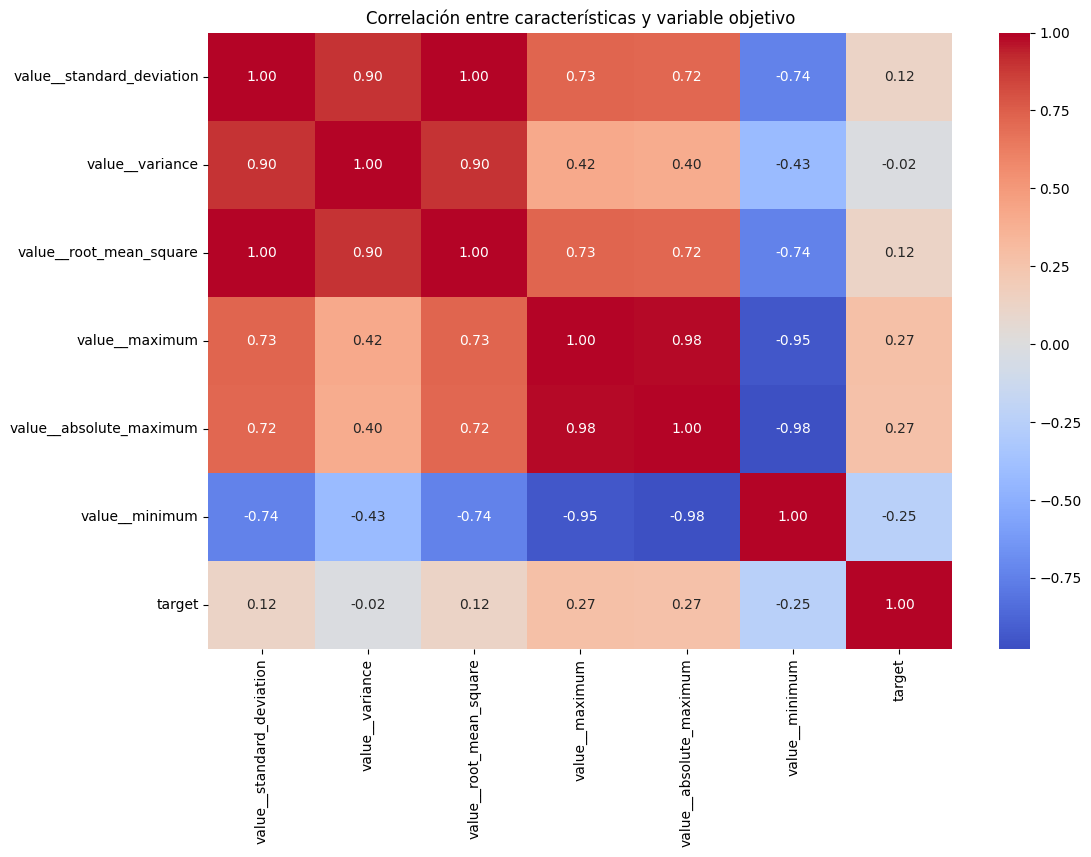

In [28]:
# Hazme una representación gráfica (usando seaborn) de la correlación entre las features y la variable target (y_train_series)

plt.figure(figsize=(12, 8))
sns.heatmap(temp.corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlación entre características y variable objetivo")
plt.show()


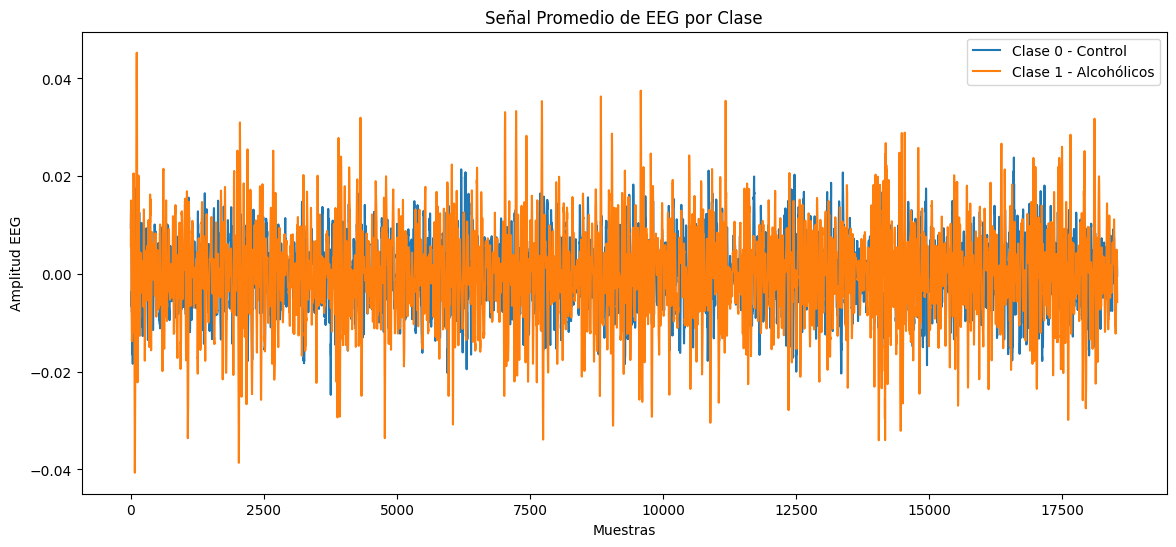

In [38]:
plt.figure(figsize=(14, 6))
for label in np.unique(y_train):
    mean_signal = X_train[y_train == label, 0, :].mean(axis=0)
    plt.plot(mean_signal, label=f'Clase {label} - {"Control" if label==0 else "Alcohólicos"}')
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud EEG")
    plt.title("Señal Promedio de EEG por Clase")
    plt.legend()
